<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/European_Call_jax_1stock_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test (Skip this if not trying to test, to make sure that functions are defined correctly in cells below without running this cell)

In [17]:
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T):
  return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

numstocks = 1
numsteps = 50
numpaths = 1000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.0807]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.2597*0.2597
initial_stocks = jnp.array([0.7178]*numstocks) # must be float
T = 1.0
K = 0.2106

fast_simple = jax.jit(Brownian_motion, static_argnums=2)
keys = jax.random.split(key, numpaths)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))
#%timeit optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T)

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))
#%timeit goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T)

0.5234
[0.999822]


# Construct Neural Net

In [9]:
%%writefile cupy_dataset.py
# version 1, 2, 6
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, keys): # need to pass 'keys'
    return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

###################################################################################################
# these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
###################################################################################################

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          rng = jax.random.PRNGKey(self.seed)
          rng, key = jax.random.split(rng)

          ################################################################################################### generate random input numbers

          initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 1.0)

          corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.3)
          cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

          r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
          drift = r

          T = self.T
          K = np.random.random(1) * 1.0

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas
          
          keys = jax.random.split(key, self.N_PATHS)

          European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'
          gooptionvalue = jax.grad(optionvalueavg, argnums=1)
          Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price
          Y[op, 1:] = cupy.array(Deltas, dtype=cupy.float32) # remember to change this!

          # T, K, S, sigma, mu, r
          paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 1000000, batch = 2, seed = 15, stocks=1) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

(tensor([[1.0000, 0.3615, 0.8488, 0.0537, 0.0054, 0.0054],
        [1.0000, 0.3045, 0.2754, 0.1590, 0.0306, 0.0306]], device='cuda:0'), tensor([[0.4893, 1.0000],
        [0.0099, 0.3607]], device='cuda:0'))
(tensor([[1.0000, 0.2641, 0.1117, 0.0750, 0.0918, 0.0918],
        [1.0000, 0.2106, 0.7178, 0.2597, 0.0807, 0.0807]], device='cuda:0'), tensor([[0.0000, 0.0000],
        [0.5237, 1.0002]], device='cuda:0'))


In [1]:
%%writefile cupy_dataset.py
# version 3, 4, 5, 7
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, keys): # need to pass 'keys'
    return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))
    # must use '-1' not 'numsteps', or else grad will be 0

###################################################################################################
# these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
###################################################################################################

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          rng = jax.random.PRNGKey(self.seed)
          rng, key = jax.random.split(rng)

          ################################################################################################### generate random input numbers

          initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 200.0)

          corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.4)
          cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

          r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
          drift = r # To match BS, use drift = r

          T = self.T
          K = np.random.random(1) * 200.0

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas
          
          keys = jax.random.split(key, self.N_PATHS)

          European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'
          gooptionvalue = jax.grad(optionvalueavg, argnums=1)
          Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price
          Y[op, 1:] = cupy.array(Deltas, dtype=cupy.float32)

          paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 10000, batch = 2, seed = 15, stocks=3) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

Writing cupy_dataset.py


In [ ]:
# #%%writefile cupy_dataset.py
# import cupy
# import jax
# import jax.numpy as jnp
# from jax import random
# from jax import jit
# import numpy as np
# from torch.utils.dlpack import from_dlpack

# def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
#     stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
#     stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
#                             jax.ops.index[0],         # initialization of stock prices
#                             initial_stocks)
#     noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
#     sigma = jnp.diag(cov) ** 0.5
#     dt = T / numsteps
#     def time_step(t, val):
#         dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
#         val = jax.ops.index_update(val,
#                             jax.ops.index[t],
#                             val[t-1] * dx)
#         return val
#     return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

# def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T, keys): # need to pass 'keys'
#     return jnp.mean((jnp.maximum(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T)[:,-1,:], axis=1)-K,0)) * jnp.exp(-r[0] * T))

# ###################################################################################################
# # these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
# fast_simple = jax.jit(Brownian_motion, static_argnums=2)
# batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
# ###################################################################################################

# class OptionDataSet(object):
    
#     def __init__(self, max_len, number_path, batch, stocks):
#         self.num = 0
#         self.max_length = max_len
#         self.N_PATHS = number_path
#         self.N_STEPS = 50
#         self.N_BATCH = batch
#         self.N_STOCKS = stocks
#         self.T = 1.0 # assume T = 1, use float here
#         # self.seed = seed
#         # np.random.seed(seed)
        
#     def __len__(self):
#         return self.max_length
        
#     def __iter__(self):
#         self.num = 0
#         return self
    
#     def __next__(self):
#         if self.num >= self.max_length:
#             raise StopIteration
        
#         Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
#         X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

#         for op in range(self.N_BATCH):
          
#           np.random.seed(np.random.randint(10000))
#           rng = jax.random.PRNGKey(np.random.randint(10000))
#           rng, key = jax.random.split(rng)

#           ################################################################################################### generate random input numbers

#           initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 1.0)

#           corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
#           sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.3)
#           cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

#           r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
#           drift = jnp.array(np.random.random(self.N_STOCKS) * 0.1)

#           T = self.T
#           K = np.random.random(1) * 1.0

#           ###################################################################################################
#           ################################################################################################### apply functions to compute price and deltas
          
#           keys = jax.random.split(key, self.N_PATHS)

#           European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'
#           gooptionvalue = jax.grad(optionvalueavg, argnums=1)
#           Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, T, keys) # need to pass 'keys'

#           ###################################################################################################
#           ################################################################################################### store input and output numbers in X and Y

#           Y[op, 0] = European_Call_price
#           Y[op, 1:4] = cupy.array(Deltas, dtype=cupy.float32)

#           # T, K, S, sigma, mu, r
#           paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
#           paras = np.column_stack(paras).reshape(1,-1)[0]
#           X[op,] = cupy.array(paras)

#           ###################################################################################################

#         self.num += 1
#         return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 10000, batch = 2, stocks=3) # When training, change to random seed
# for i in ds:
#     print(i)

In [13]:
%%writefile model.py
# version 1,2
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1.0, 1.0, 1.0, 0.3, 0.1, 0.1]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


In [2]:
%%writefile model.py
# version 3,7
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1) # 1 outputs: price
        self.register_buffer('norm',
                             torch.tensor([1, 200.0, 200.0, 0.4, 0.1, 0.1]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


In [ ]:
# version 4, 5
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 2) # 2 outputs: price, delta
        self.register_buffer('norm',
                             torch.tensor([1, 200.0, 200.0, 0.4, 0.1, 0.1]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


In [ ]:
# version 6
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6*1, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 2) # 2 outputs: price, delta
        self.register_buffer('norm',
                             torch.tensor([1.0, 1.0, 1.0, 0.3, 0.1, 0.1]*1)) # don't use numpy here - will give error later
                                                                               # T, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


# Train Neural Net

In [3]:
!pip install pytorch-ignite

     |████████████████████████████████| 240 kB 12.8 MB/s 


In [ ]:
# version 1 & version 3 (200)
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y = y[:,0].reshape(-1,1)
    #print(y)
    y_pred = model(x)
    #print(y_pred)
    loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
    #print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

loss 97.98233032226562 average time 0.050657296949999875 iter num 20
loss 11.477714538574219 average time 0.02677511827500183 iter num 40
loss 8.203895568847656 average time 0.018795166516666958 iter num 60
loss 11.508925437927246 average time 0.01489475403749978 iter num 80
loss 7.16341495513916 average time 0.012507266819999358 iter num 100
loss 4.0047831535339355 average time 0.051545926849996704 iter num 20
loss 9.011444091796875 average time 0.027256455625000342 iter num 40
loss 20.87165069580078 average time 0.019207970266668893 iter num 60
loss 4.224143981933594 average time 0.015154346012502628 iter num 80
loss 4.319762706756592 average time 0.012694993320003505 iter num 100
loss 19.631484985351562 average time 0.050563782799997625 iter num 20
loss 12.390233039855957 average time 0.026728059974998074 iter num 40
loss 6.4824748039245605 average time 0.018758720949999013 iter num 60
loss 6.20057487487793 average time 0.014814617624999471 iter num 80
loss 3.8055574893951416 averag

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [7]:
# version 2, 7
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 100000, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed

def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 0]).cuda()  # let delta weight = 0 for testing
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 100)

loss 2408.8115234375 average time 0.21569903545000102 iter num 20
loss 2126.212890625 average time 0.12378502192499923 iter num 40
loss 2588.671142578125 average time 0.09295705038333797 iter num 60
loss 921.111572265625 average time 0.07758783802500915 iter num 80
loss 1434.099853515625 average time 0.0684344519600097 iter num 100
loss 89.68195343017578 average time 0.10293295500001705 iter num 20
loss 25.545438766479492 average time 0.06765549510001279 iter num 40
loss 18.984630584716797 average time 0.055631484150004934 iter num 60
loss 12.278401374816895 average time 0.04941242690000536 iter num 80
loss 15.778316497802734 average time 0.04580528509999795 iter num 100
loss 10.017118453979492 average time 0.10074550609999733 iter num 20
loss 16.154296875 average time 0.06602838105000046 iter num 40
loss 10.468088150024414 average time 0.05471895543333479 iter num 60
loss 3.5554184913635254 average time 0.04910922859998834 iter num 80
loss 5.760096549987793 average time 0.045691191629

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
# version 4
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    #print(y)
    y_pred = model(x)
    #print(y_pred)
    loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
    #print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

loss 605.4209594726562 average time 0.05229364139999291 iter num 20
loss 1784.724609375 average time 0.027603255849994922 iter num 40
loss 699.6022338867188 average time 0.01937843339999006 iter num 60
loss 438.4067077636719 average time 0.015227208274991 iter num 80
loss 280.857666015625 average time 0.012798372289991563 iter num 100
loss 30.755651473999023 average time 0.050733957999989344 iter num 20
loss 12.27236270904541 average time 0.02674691677499368 iter num 40
loss 3.4057724475860596 average time 0.01876086056666016 iter num 60
loss 9.469303131103516 average time 0.014774990999991643 iter num 80
loss 10.845123291015625 average time 0.012378052689994092 iter num 100
loss 5.970004558563232 average time 0.05093526560000328 iter num 20
loss 4.132028102874756 average time 0.026959735800005546 iter num 40
loss 6.6139397621154785 average time 0.018893525783336904 iter num 60
loss 2.841221809387207 average time 0.014964001250008607 iter num 80
loss 4.092901229858398 average time 0.01

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
# version 5, 6
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 100000, batch =32, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    #print(y)
    y_pred = model(x)
    #print(y_pred)
    loss = ((y_pred - y) ** 2).mean(axis=0).sum()
    #print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output * 10000, 'average time', timer.value(), 'iter num', iter) # * 10000 for version 6
        
trainer.run(dataset, max_epochs = 50)

loss 51222272.0 average time 0.0729838983999798 iter num 20
loss 51352472.0 average time 0.037968114574982795 iter num 40
loss 58849488.0 average time 0.02627112149999296 iter num 60
loss 62303808.0 average time 0.020432651712485494 iter num 80
loss 53211420.0 average time 0.016891290730004584 iter num 100
loss 27532958.0 average time 0.07092350649995752 iter num 20
loss 28572300.0 average time 0.03688633032495545 iter num 40
loss 24224100.0 average time 0.025541296966624334 iter num 60
loss 23608792.0 average time 0.019869637412466546 iter num 80
loss 24285892.0 average time 0.016463919099965096 iter num 100
loss 24764718.0 average time 0.07172510180000699 iter num 20
loss 20503604.0 average time 0.03728955617502834 iter num 40
loss 20455224.0 average time 0.02579590253335482 iter num 60
loss 15537903.0 average time 0.020063273662509575 iter num 80
loss 17011308.0 average time 0.016607255060011993 iter num 100
loss 7308837.5 average time 0.0735671064999451 iter num 20
loss 4744317.0 a

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

**Save Model**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import torch
model_save_name = 'jax_european_1stock_version7_3.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import torch
model_save_name = 'jax_european_1stock_version2_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [16]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=6, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1, bias=True)
)


**Continue to train model**

In [45]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
import torch
from torch import Tensor
from torch.autograd import grad
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 1) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 1000000, batch = 16, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)

    def compute_deltas(x):
      inputs = x
      inputs.requires_grad = True
      first_order_gradient = grad(model(inputs), inputs, create_graph=False)
      return first_order_gradient[0][[2]]

    deltas = torch.stack([compute_deltas(x) for x in torch.unbind(x)], dim=0)
    y_pred = torch.cat((y_pred, deltas), 1)

    loss_weight = torch.tensor([1, 0]).cuda()  # let delta weight = 0 for testing
    loss_weight_normalized = loss_weight/loss_weight.sum()
    loss = ((y_pred - y) ** 2 * loss_weight_normalized).mean(axis=0).sum() # compute weighted MSE between the 2 arrays

    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 10

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter) # print by multiplying 10000 -> easier to read (actual loss function isn't amplified)
        
trainer.run(dataset, max_epochs = 20)

model_save_name = 'jax_european_1stock_version7_4.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 13.031719207763672 average time 0.3516769881000073 iter num 10
loss 2.8753252029418945 average time 0.1843993639002292 iter num 20
loss 6.898102283477783 average time 0.1290628192336347 iter num 30
loss 0.5391082167625427 average time 0.10116679775028388 iter num 40
loss 0.7777198553085327 average time 0.08436501544019848 iter num 50
loss 0.3032364845275879 average time 0.07326824943350706 iter num 60
loss 0.3129631280899048 average time 0.06527927104299514 iter num 70
loss 0.04416505992412567 average time 0.05930497996255326 iter num 80
loss 0.188725084066391 average time 0.05463837472238487 iter num 90
loss 0.11835906654596329 average time 0.05103864909018739 iter num 100
loss 0.1419709175825119 average time 0.35059288259944876 iter num 10
loss 0.2971019148826599 average time 0.1840592314494643 iter num 20
loss 0.39013251662254333 average time 0.12847000879968012 iter num 30
loss 0.12671756744384766 average time 0.10075981384970874 iter num 40
loss 0.38977205753326416 average ti

In [ ]:
# version 4
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 1000000, batch = 8, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    #print(y)
    y_pred = model(x)
    #print(y_pred)
    loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
    #print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 50)

model_save_name = 'jax_european_1stock_version4_2.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: /usr/local/lib/python3.7/dist-packages/ignite/contrib/handlers/param_scheduler.py has been moved to /ignite/handlers/param_scheduler.py and will be removed in version 0.6.0.
 Please refer to the documentation for more details.
  if __name__ == '__main__':


loss 2.046630620956421 average time 0.4740749346999905 iter num 20
loss 1.799705147743225 average time 0.23847036637498037 iter num 40
loss 0.7313764095306396 average time 0.15993198333332734 iter num 60
loss 0.1241651177406311 average time 0.12063063373749117 iter num 80
loss 0.13611027598381042 average time 0.09706118446998743 iter num 100
loss 0.15536171197891235 average time 0.08598583745000496 iter num 20
loss 0.5444387197494507 average time 0.04441163370000254 iter num 40
loss 0.24326755106449127 average time 0.030551000666673645 iter num 60
loss 0.036943838000297546 average time 0.023603397050001716 iter num 80
loss 0.016648493707180023 average time 0.019442864039992857 iter num 100
loss 0.2033129781484604 average time 0.08602859795000768 iter num 20
loss 0.09743532538414001 average time 0.04441264245002117 iter num 40
loss 0.08224725723266602 average time 0.030554118316676218 iter num 60
loss 0.06957727670669556 average time 0.023611417975004656 iter num 80
loss 0.0191129092127

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [ ]:
# version 5
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 1000000, batch = 8, seed = np.random.randint(10000), stocks = 1) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    #print(y)
    y_pred = model(x)
    #print(y_pred)
    loss = ((y_pred - y) ** 2).mean(axis=0).sum()
    #print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 20)

model_save_name = 'jax_european_1stock_version5_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 8.121227264404297 average time 0.19850110825002504 iter num 20
loss 1.4115912914276123 average time 0.10062621462502648 iter num 40
loss 4.279460430145264 average time 0.068014872200024 iter num 60
loss 1.859859824180603 average time 0.05172370921252423 iter num 80
loss 1.0982649326324463 average time 0.041922518410010524 iter num 100
loss 1.064512848854065 average time 0.08594591344999572 iter num 20
loss 4.192468643188477 average time 0.044336736474974714 iter num 40
loss 1.359633445739746 average time 0.030487323083320916 iter num 60
loss 5.919878005981445 average time 0.02359727771249709 iter num 80
loss 1.3565268516540527 average time 0.019426683029992092 iter num 100
loss 1.430983543395996 average time 0.08597827774997313 iter num 20
loss 8.961183547973633 average time 0.04433867122500033 iter num 40
loss 4.0858235359191895 average time 0.03046528321669181 iter num 60
loss 1.5352342128753662 average time 0.023528458975027887 iter num 80
loss 1.5280840396881104 average time 0

In [ ]:
a = np.array([[2.5661e+01, 9.5063e-01],
        [6.5737e-07, 3.5066e-06]])
b = np.array([[32.7189,  0.9209],
        [ 1.5464,  0.3001]])
((a-b)**2).mean(axis=0).sum()

26.148122557568712

#Results

In [16]:
import torch
inputs = torch.tensor([[1, 0.8, 0.8, 0.25, 0.05, 0.05]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (0.098688, 0.627409)

price: tensor([[1.6141]], device='cuda:0', grad_fn=<AddmmBackward>)


tensor([0.3334], device='cuda:0')

In [ ]:
numstocks = 1
numsteps = 50
numpaths = 1000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.05]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([0.8]*numstocks) # must be float
T = 1.0
K = 0.8

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))

0.09872279
[0.62781]


In [49]:
# version 7
import torch
inputs = torch.tensor([[1, 80, 80, 0.25, 0.05, 0.05]]).cuda() # T, K, S, sigma, mu, r
print('price: ' + str(model(inputs.float())))

inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient[0][[2]]

# price, delta
# should be around (8.058222, 0.47825053)

price: tensor([[9.0365]], device='cuda:0', grad_fn=<AddmmBackward>)


tensor([0.6460], device='cuda:0')

In [50]:
# version 7
numstocks = 1
numsteps = 50
numpaths = 1000000

rng = jax.random.PRNGKey(np.random.randint(10000))
rng, key = jax.random.split(rng)

drift = jnp.array([0.05]*numstocks)
r = drift
cov = jnp.identity(numstocks)*0.25*0.25
initial_stocks = jnp.array([80.0]*numstocks) # must be float
T = 1.0
K = 80.0

# option price
print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, T))

# delta test
goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, T))

9.870231
[0.6271614]


In [ ]:
import torch
inputs = torch.tensor([[1, 110.0, 100.0, 0.25, 0.05, 0.05]]).cuda() # T, K, S, sigma, mu, r
print('price, delta: ' + str(model(inputs.float())))

# inputs.requires_grad = True
# x = model(inputs.float())
# x.backward()
# first_order_gradient = inputs.grad
# first_order_gradient[0][[2]]

# should be 8.058, 0.478

price, delta: tensor([[7.9458, 0.5370]], device='cuda:0', grad_fn=<AddmmBackward>)


# Delta

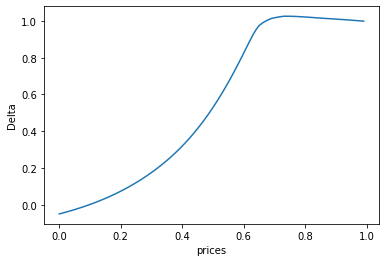

In [17]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S):
    inputs = torch.tensor([[1, 0.5, S, 0.25, 0.05, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(0, 1, 0.01)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

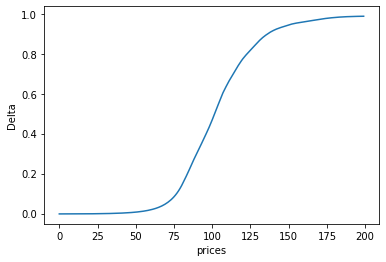

In [52]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S):
    inputs = torch.tensor([[1, 110.0, S, 0.25, 0.05, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(0, 200, 1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

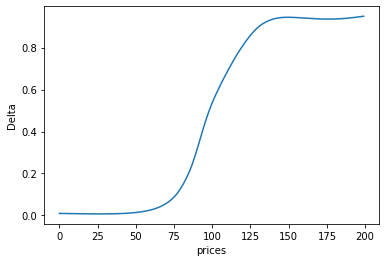

In [ ]:
import pylab
import numpy as np
prices = np.arange(0, 200, 1)
deltas = []
for p in prices:
    inputs = torch.tensor([[1, 110.0, p, 0.25, 0.05, 0.05]]).cuda() # T, K, S, sigma, mu, r
    deltas.append(model(inputs.float())[0][1])
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig